In [ ]:
"""
Created on Wed Dec  9 11:44:55 2020

@author: Nir Bar
"""

import cv2
import matplotlib.pyplot as plt
import numpy as np
import h5py
import keras
import tensorflow
from xlwt import Workbook 
from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive')




# creating x_train y_train

In [18]:
x_train = []
y_train = []
# getting the chars from the second train data
db = h5py.File('gdrive/My Drive/SynthText.h5', 'r')
im_names = list(db['data'].keys())
for k in range (len(im_names)):# runnig throw all data
        im = im_names[k]
        imgs = db['data'][im][:]#the names of the images have no effect on the model
        font = db['data'][im].attrs['font']# the type of the font
        txt = db['data'][im].attrs['txt'] # the char
        charBB = db['data'][im].attrs['charBB']# the position of the char
        wordBB = db['data'][im].attrs['wordBB']# the position of the word
        # building a loop to get evry char in to a 50*50 image
        for i in range(len(charBB[0,0])): 
            pts1 = np.float32([charBB[:,:,i].T[0],charBB[:,:,i].T[1],charBB[:,:,i].T[3],charBB[:,:,i].T[2]])
            pts2 = np.float32([[0,0],[400,0],[0,400],[400,400]])
            M = cv2.getPerspectiveTransform(pts1,pts2)
            dst = cv2.warpPerspective(imgs,M,(400,400))
            dst = cv2.pyrDown(cv2.pyrDown((cv2.pyrDown(dst))))
            dst = (dst/255.).astype(np.float16)
            # set the x_train and y_train for the model
            x_train.append(dst)
            y_train.append(font[i].decode('UTF-8'))

In [19]:
# getting the chars from the second train data
db = h5py.File('gdrive/My Drive/train.h5', 'r')
im_names = list(db['data'].keys())
for k in range (len(im_names)):
        im = im_names[k]
        imgs = db['data'][im][:]
        font = db['data'][im].attrs['font']
        txt = db['data'][im].attrs['txt']
        charBB = db['data'][im].attrs['charBB']
        wordBB = db['data'][im].attrs['wordBB']
        for i in range(len(charBB[0,0])):
            pts1 = np.float32([charBB[:,:,i].T[0],charBB[:,:,i].T[1],charBB[:,:,i].T[3],charBB[:,:,i].T[2]])
            pts2 = np.float32([[0,0],[400,0],[0,400],[400,400]])
            M = cv2.getPerspectiveTransform(pts1,pts2)
            dst = cv2.warpPerspective(imgs,M,(400,400))
            dst = cv2.pyrDown(cv2.pyrDown((cv2.pyrDown(dst))))
            dst = (dst/255.).astype(np.float16)
            x_train.append(dst)
            y_train.append(font[i].decode('UTF-8'))


# Creating x_val y_val

In [20]:
# creating the valuation data will be simillar to the train data
x_val = []
y_val = []
db = h5py.File('gdrive/My Drive/SynthText_val.h5', 'r')
im_names = list(db['data'].keys())
for k in range(len(im_names)):
        im = im_names[k]
        imgs = db['data'][im][:]
        font = db['data'][im].attrs['font']
        txt = db['data'][im].attrs['txt']
        charBB = db['data'][im].attrs['charBB']
        wordBB = db['data'][im].attrs['wordBB']
        for i in range(len(charBB[0,0])):
            pts1 = np.float32([charBB[:,:,i].T[0],charBB[:,:,i].T[1],charBB[:,:,i].T[3],charBB[:,:,i].T[2]])
            pts2 = np.float32([[0,0],[400,0],[0,400],[400,400]])
            M = cv2.getPerspectiveTransform(pts1,pts2)
            dst = cv2.warpPerspective(imgs,M,(400,400))
            dst = cv2.pyrDown(cv2.pyrDown((cv2.pyrDown(dst))))
            dst = (dst/255.).astype(np.float16)
            x_val.append(dst)
            y_val.append(font[i].decode('UTF-8'))



# preprocessing data

In [21]:
# transform all the data for the model into asarray type
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_val = np.asarray(x_val)
y_val = np.asarray(y_val)

In [22]:
def to_numeric(x):
  '''function that gives the labels integers values.'''
    return [0 if i=='Ubuntu Mono' else 1 if i=='Skylark' else 2 for i in x]
y_train = to_numeric(y_train)
y_val = to_numeric(y_val)

In [23]:
# we will set the labels data to fit ti the image objects size and shape
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes=3)
y_val = tensorflow.keras.utils.to_categorical(y_val, num_classes=3)
y_train = tensorflow.constant(y_train, shape=[38308,3])
y_val = tensorflow.constant(y_val, shape=[8198,3])
tensorflow.dtypes.cast(y_train, tensorflow.uint8)
tensorflow.dtypes.cast(y_val, tensorflow.uint8)

<tf.Tensor: shape=(8198, 3), dtype=uint8, numpy=
array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=uint8)>

# the model

In [62]:
def initialize_model():
    model = tensorflow.keras.models.Sequential([
    # Note the input shape is the desired size of the image 50x50 with 3 bytes color
    # This is the first convolution
    tensorflow.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(50, 50,3)),
    tensorflow.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    # tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tensorflow.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tensorflow.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    # tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),
    #tensorflow.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    #tensorflow.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tensorflow.keras.layers.Flatten(),
    tensorflow.keras.layers.Dropout(0.5),
    # 4096 neuron hidden layer
    tensorflow.keras.layers.Dense(4096, activation='relu'),
    tensorflow.keras.layers.Dense(3, activation='softmax'),
])
    return model

In [63]:
def compile_model(model):
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [66]:
#trainning the model with the data and labels
model = initialize_model()
model = compile_model(model)

es = EarlyStopping(patience=5, verbose=1, restore_best_weights=True)

history = model.fit(x_train, y_train,
                    validation_split=0.3,
                    callbacks=[es], 
                    epochs=100, 
                    batch_size=32)

Epoch 1/100
838/838 [==============================] - 15s 18ms/step - loss: 0.7168 - accuracy: 0.7034 - val_loss: 0.2507 - val_accuracy: 0.9155
Epoch 2/100
838/838 [==============================] - 14s 17ms/step - loss: 0.2350 - accuracy: 0.9103 - val_loss: 0.1791 - val_accuracy: 0.9336
Epoch 3/100
838/838 [==============================] - 14s 17ms/step - loss: 0.1780 - accuracy: 0.9331 - val_loss: 0.1543 - val_accuracy: 0.9398
Epoch 4/100
838/838 [==============================] - 14s 17ms/step - loss: 0.1437 - accuracy: 0.9452 - val_loss: 0.1474 - val_accuracy: 0.9441
Epoch 5/100
838/838 [==============================] - 14s 17ms/step - loss: 0.1258 - accuracy: 0.9510 - val_loss: 0.1381 - val_accuracy: 0.9480
Epoch 6/100
838/838 [==============================] - 14s 17ms/step - loss: 0.1095 - accuracy: 0.9564 - val_loss: 0.1375 - val_accuracy: 0.9476
Epoch 7/100
838/838 [==============================] - 14s 17ms/step - loss: 0.0974 - accuracy: 0.9618 - val_loss: 0.1490 - val_ac

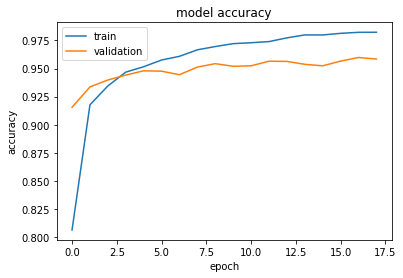

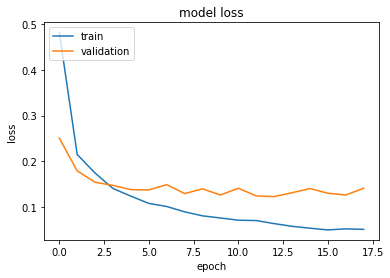

In [67]:
#a plot to the models accuracy as a function of the epoches
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
#a plot to the models loss as a function of the epoches
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [68]:
#we will check for the models ideals accuracy and loss
score = model.evaluate(x_val, y_val, verbose=False)
print('Loss: {}'.format(score[0]))
print('Accuracy: {}%'.format(np.round(10000*score[1])/100))

Loss: 0.09539802372455597
Accuracy: 96.94%


In [69]:
model.save('gdrive/My Drive/project_model.h5')

In [70]:
#load the model from here #####################################
###############################################################
###############################################################
###############################################################
model = keras.models.load_model('gdrive/My Drive/project_model.h5')

In [71]:
#startting work on the test from here

In [72]:
#getting the data from the test file
x_test = []
db = h5py.File('gdrive/My Drive/test.h5', 'r')# add your test path to here
im_names = list(db['data'].keys())
for k in range (len(im_names)):
        im = im_names[k]
        imgs = db['data'][im][:]
        txt = db['data'][im].attrs['txt']
        charBB = db['data'][im].attrs['charBB']
        wordBB = db['data'][im].attrs['wordBB']
        for i in range(len(charBB[0,0])):
            pts1 = np.float32([charBB[:,:,i].T[0],charBB[:,:,i].T[1],charBB[:,:,i].T[3],charBB[:,:,i].T[2]])
            pts2 = np.float32([[0,0],[400,0],[0,400],[400,400]])
            M = cv2.getPerspectiveTransform(pts1,pts2)
            dst = cv2.warpPerspective(imgs,M,(400,400))
            dst = cv2.pyrDown(cv2.pyrDown((cv2.pyrDown(dst))))
            dst = (dst/255.).astype(np.float16)
            x_test.append(dst)
        for i in range(len(txt)):#check if there are words with one or two chars
          if len(txt[i])==1:
            print('stop')
          if len(txt[i])==2:
            print('stop')


In [75]:
#no labels
x_test=np.array(x_test)

In [76]:
y_prob = model.predict(x_test)# an array for the models prediction, values from 0 to 1
y_prob_check = y_prob.copy()# an array to check if the loop works
# change to binar values
for i in range(len(y_prob)):
    if max(y_prob[i,0],y_prob[i,1],y_prob[i,2])==y_prob[i,0]:
      y_prob[i] = [1,0,0]
    if max(y_prob[i,0],y_prob[i,1],y_prob[i,2]) == y_prob[i,1]: 
      y_prob[i] = [0,1,0]
    if max(y_prob[i,0],y_prob[i,1],y_prob[i,2]) == y_prob[i,2]:
      y_prob[i] = [0,0,1]
# in the same word all the fonts are the same, 
#we will make sure that all the chars in the same word are ditected as the same font
for i in range(len(y_prob)-2):
  if (y_prob[i,0] == y_prob[i+2,0]):
    if (y_prob[i,0]!= y_prob[i+1,0]):
      y_prob[i+1,0] = y_prob[i,0]  
for i in range(len(y_prob)-2):
  if (y_prob[i,1] == y_prob[i+2,1]):
    if (y_prob[i,1]!= y_prob[i+1,1]):
      y_prob[i+1,1] = y_prob[i,1]
for i in range(len(y_prob)-2):
  if (y_prob[i,2] == y_prob[i+2,2]):
    if (y_prob[i,2]!= y_prob[i+1,2]):
      y_prob[i+1,2] = y_prob[i,2]  


In [77]:
# make sure we have no zero vectors
for i in range(len(y_prob)):
  if (y_prob[i,0] == 0):
    if (y_prob[i,1] == 0):
       if (y_prob[i,2] == 0):
         y_prob[i]=y_prob[i-1]


In [78]:
# getting the letters for the excel table
def Convert(string):#function that splits string to chars 
  list1 = [] 
  list1[:0]=string 
  return list1 
txt_table = []#an array that will contain all the texts
pic_name = []#an array that will contain all the pictures names
temp_txt =[]#a temporery array that will contain all the texts in words
for i in range(len(im_names)):
    im = im_names[i]
    txt = db['data'][im].attrs['txt']
    for k in range(len(txt)):
      temp_txt = Convert(txt[k].decode('UTF-8'))
      for j in range(len(temp_txt)):#second loop for letters from words
        txt_table.append(temp_txt[j])
        pic_name.append(im_names[i])

In [80]:
# Writing to an excel sheet 
import xlwt
from xlwt import Workbook 
  
# Workbook is created 
wb = Workbook() 
# add_sheet is used to create sheet. 
sheet1 = wb.add_sheet('Sheet 1')
sheet1.write(0,0,'sn')
sheet1.write(0,1,'image')
sheet1.write(0,2,'char')
sheet1.write(0,3,'skylark')
sheet1.write(0,4,'sweet pup')
sheet1.write(0,5,'ubunto mono')
for i in range(len(y_prob)):
  sheet1.write(i+1,1,pic_name[i])
  sheet1.write(i+1,2,txt_table[i])
  sheet1.write(i+1,5,int(y_prob[i,0]))
  sheet1.write(i+1,3,int(y_prob[i,1]))
  sheet1.write(i+1,4,int(y_prob[i,2]))
wb.save('test_results.csv')

In [81]:
from google.colab import files
files.download('test_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>